Assuming that train-test datasets are for training-validating models and validation dataset for fine-tuning (i think the right way is the other way around let's work with:
- always the same validation dataset: 150 pics randomly chosen of each class
- with the rest of pics:
  - regular folders: working with 5 folders, each one shuffled, dividing pics 80% for train dataset and 20% for test dataset.
  - irregular folders: each one shuffled, 20% always for the test dataset, the volume of train dataset is decreasing is time.

How to create that folders here => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/3folders_08trainds/src/creating_5_subfolders_for_kfoldslike_validation.ipynb

In [ ]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 22 14:59:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [ ]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from my_functions202202 import generic_last_2layers, plotting_model, model_evaluation, classification_report_pic, confusion_matrix_report

import numpy as np
%matplotlib inline

# navigating through folder
import os

- paths

In [ ]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
val_folder = base_folder+"input/dataset_1val_5traintest_folders/val_ds/"
print(val_folder)
# regular folders for train set
reg_input = base_folder+"input/dataset_1val_5traintest_folders/train_test_ds/traintest_regular_partitions/"
irreg_input = base_folder+"input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/val_ds/


- functions

In [ ]:
#my_functions202202.py

- common parameters

In [ ]:
image_size = (128,128)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

In [ ]:
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07)
         }

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
val_ds = image_dataset_from_directory(
    val_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 750 files belonging to 5 classes.


# Regular partitions for traint set

In [ ]:
os.listdir(reg_input)

['fold2', 'fold4', 'fold0', 'fold3', 'fold1']

In [ ]:
total = 0
for root, dirs, files in os.walk(reg_input):
    total += len(files)
    print(dirs, len(files))

['fold2', 'fold4', 'fold0', 'fold3', 'fold1'] 0
['train_ds', 'test_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 806
[] 878
[] 898
[] 652
[] 364
['Bedroom', 'Bathroom', 'Livingroom', 'Kitchen', 'Dinning'] 0
[] 220
[] 92
[] 225
[] 163
[] 202
['test_ds', 'train_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 202
[] 229
[] 225
[] 163
[] 92
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 806
[] 878
[] 898
[] 652
[] 364
['train_ds', 'test_ds'] 0
['Livingroom', 'Kitchen', 'Dinning', 'Bedroom', 'Bathroom'] 0
[] 898
[] 652
[] 806
[] 878
[] 364
['Dinning', 'Bathroom', 'Bedroom', 'Livingroom', 'Kitchen'] 0
[] 202
[] 92
[] 220
[] 225
[] 163
['test_ds', 'train_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 202
[] 220
[] 225
[] 163
[] 92
['Kitchen', 'Livingroom', 'Bathroom', 'Dinning', 'Bedroom'] 0
[] 652
[] 898
[] 364
[] 806
[] 878
['test_ds', 'train_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'B

In [ ]:
os.listdir(reg_input)

['fold2', 'fold4', 'fold0', 'fold3', 'fold1']

In [ ]:
remaining_folders = os.listdir(reg_input)[3:]
remaining_folders

['fold3', 'fold1']


 FOLDER :  fold3
train dataset
Found 3598 files belonging to 5 classes.

 test dataset
Found 902 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

 resnet50_NOdataAug_dropoutFirst007
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trai

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


29/29 [==============================] - 1129s 39s/step - loss: 49.6012 - accuracy: 0.5472 - val_loss: 314.5213 - val_accuracy: 0.2494
Epoch 2/250
29/29 [==============================] - 8s 283ms/step - loss: 385.0496 - accuracy: 0.0186 - val_loss: 190.0693 - val_accuracy: 0.1918
Epoch 3/250
29/29 [==============================] - 8s 278ms/step - loss: 304.6460 - accuracy: 0.0414 - val_loss: 102.3166 - val_accuracy: 0.3326
Epoch 4/250
29/29 [==============================] - 8s 274ms/step - loss: 286.0156 - accuracy: 0.0584 - val_loss: 102.3694 - val_accuracy: 0.3792
Epoch 5/250
29/29 [==============================] - 8s 280ms/step - loss: 228.5450 - accuracy: 0.1459 - val_loss: 71.6740 - val_accuracy: 0.4667
Epoch 6/250
29/29 [==============================] - 8s 281ms/step - loss: 232.1500 - accuracy: 0.1982 - val_loss: 77.6256 - val_accuracy: 0.4667
Epoch 7/250
29/29 [==============================] - 8s 278ms/step - loss: 181.0817 - accuracy: 0.2185 - val_loss: 65.7056 - val_acc

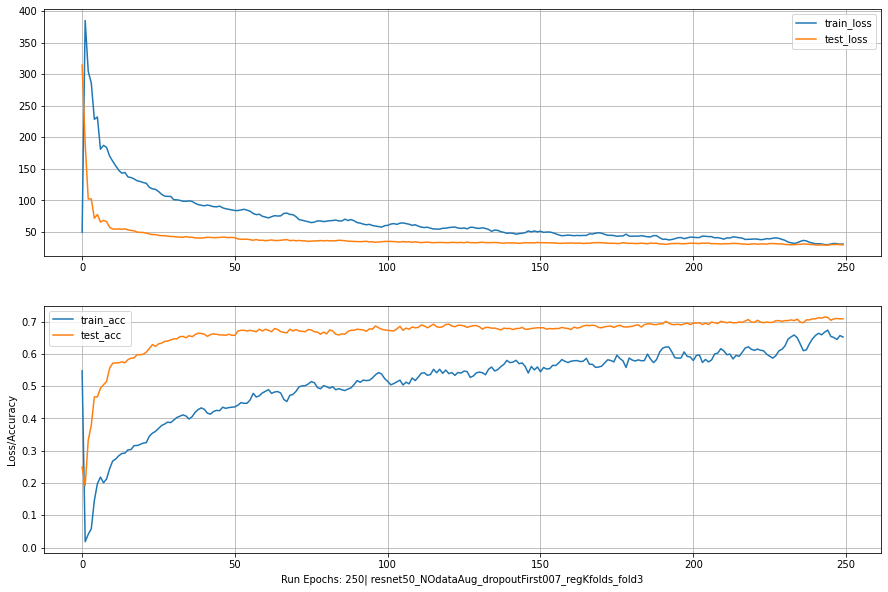

8/8 [==============================] - 2s 197ms/step - loss: 29.5603 - accuracy: 0.7084
              precision    recall  f1-score   support

     Bedroom       0.69      0.81      0.74       186
    Bathroom       0.72      0.84      0.77        79
     Dinning       0.64      0.75      0.69       173
  Livingroom       0.73      0.63      0.68       261
     Kitchen       0.78      0.63      0.69       203

    accuracy                           0.71       902
   macro avg       0.71      0.73      0.72       902
weighted avg       0.72      0.71      0.71       902



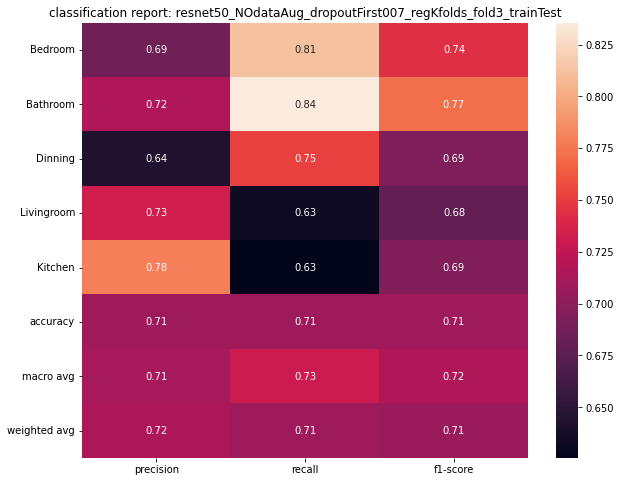

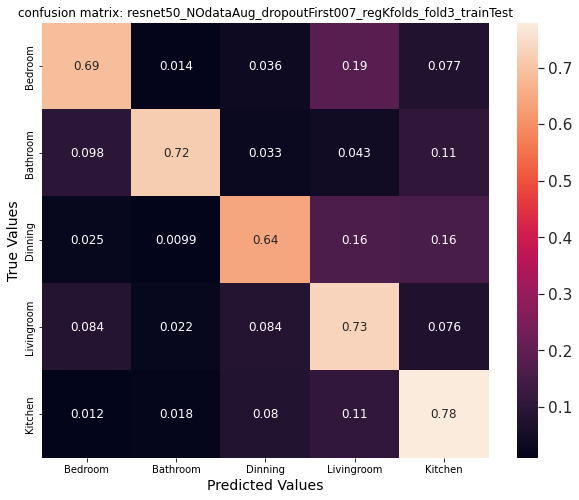

6/6 [==============================] - 200s 33s/step - loss: 25.5600 - accuracy: 0.7093
              precision    recall  f1-score   support

     Bedroom       0.82      0.84      0.83       147
    Bathroom       0.61      0.91      0.73       101
     Dinning       0.59      0.68      0.63       131
  Livingroom       0.73      0.60      0.66       182
     Kitchen       0.79      0.63      0.70       189

    accuracy                           0.71       750
   macro avg       0.71      0.73      0.71       750
weighted avg       0.72      0.71      0.71       750



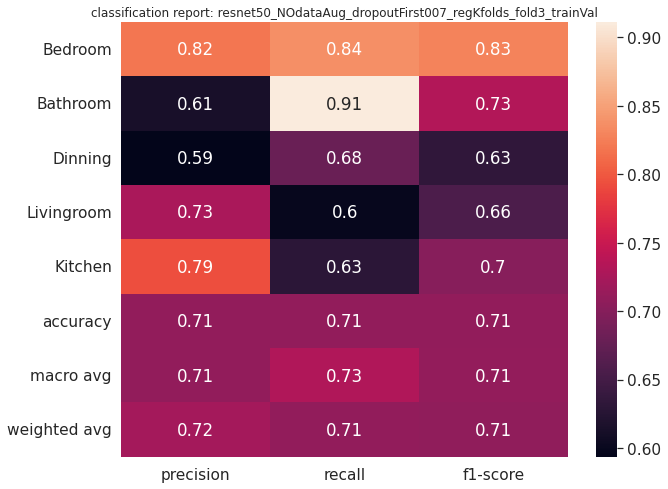

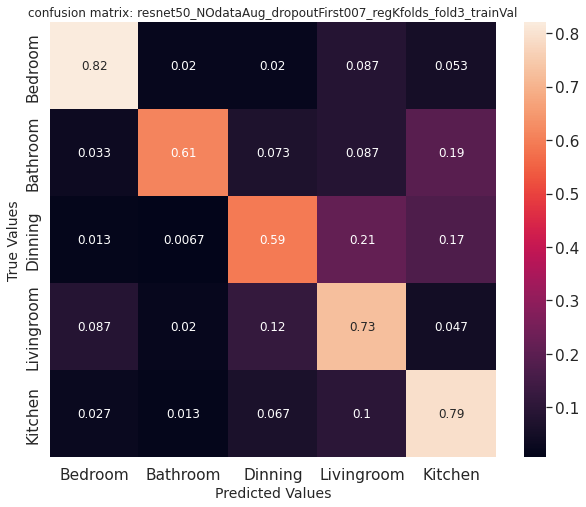


 FOLDER :  fold1
train dataset
Found 3598 files belonging to 5 classes.

 test dataset
Found 902 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

 resnet50_NOdataAug_dropoutFirst007
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trai

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


29/29 [==============================] - 783s 27s/step - loss: 36.6334 - accuracy: 0.6543 - val_loss: 12.4355 - val_accuracy: 0.8126
Epoch 2/250
29/29 [==============================] - 8s 277ms/step - loss: 39.1644 - accuracy: 0.6320 - val_loss: 12.6874 - val_accuracy: 0.8060
Epoch 3/250
29/29 [==============================] - 8s 278ms/step - loss: 37.4983 - accuracy: 0.6384 - val_loss: 12.9041 - val_accuracy: 0.8071
Epoch 4/250
29/29 [==============================] - 8s 275ms/step - loss: 35.8574 - accuracy: 0.6498 - val_loss: 13.1171 - val_accuracy: 0.8149
Epoch 5/250
29/29 [==============================] - 8s 279ms/step - loss: 34.7695 - accuracy: 0.6648 - val_loss: 12.8611 - val_accuracy: 0.8115
Epoch 6/250
29/29 [==============================] - 8s 275ms/step - loss: 33.6005 - accuracy: 0.6690 - val_loss: 12.6086 - val_accuracy: 0.8137
Epoch 7/250
29/29 [==============================] - 8s 282ms/step - loss: 34.9275 - accuracy: 0.6634 - val_loss: 12.5110 - val_accuracy: 0.81

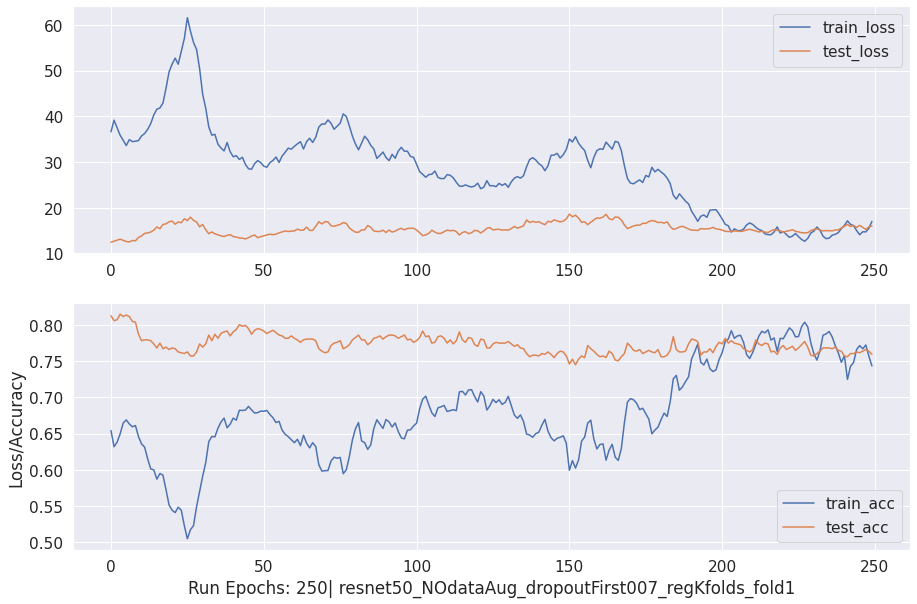

8/8 [==============================] - 2s 205ms/step - loss: 16.0059 - accuracy: 0.7594
              precision    recall  f1-score   support

     Bedroom       0.73      0.91      0.81       175
    Bathroom       0.74      0.85      0.79        80
     Dinning       0.71      0.75      0.73       193
  Livingroom       0.84      0.68      0.75       281
     Kitchen       0.75      0.71      0.73       173

    accuracy                           0.76       902
   macro avg       0.76      0.78      0.76       902
weighted avg       0.77      0.76      0.76       902



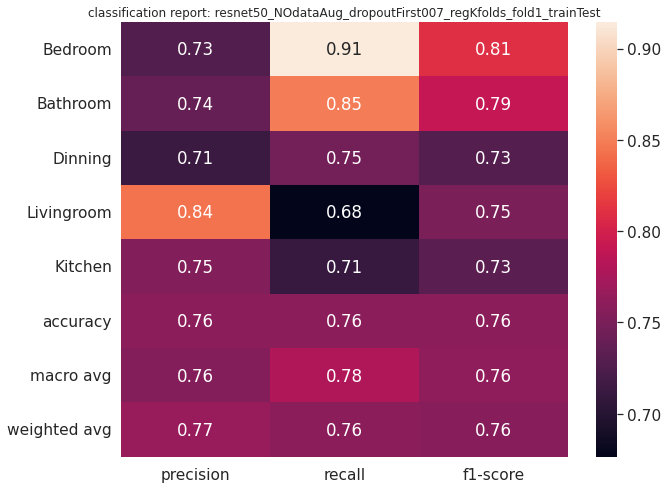

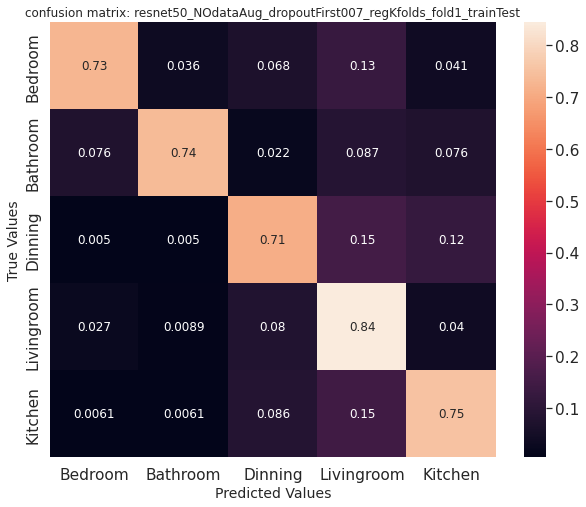

6/6 [==============================] - 1s 223ms/step - loss: 23.1635 - accuracy: 0.7093
              precision    recall  f1-score   support

     Bedroom       0.81      0.87      0.84       139
    Bathroom       0.65      0.86      0.74       114
     Dinning       0.61      0.68      0.64       134
  Livingroom       0.78      0.60      0.68       195
     Kitchen       0.70      0.62      0.66       168

    accuracy                           0.71       750
   macro avg       0.71      0.73      0.71       750
weighted avg       0.72      0.71      0.71       750



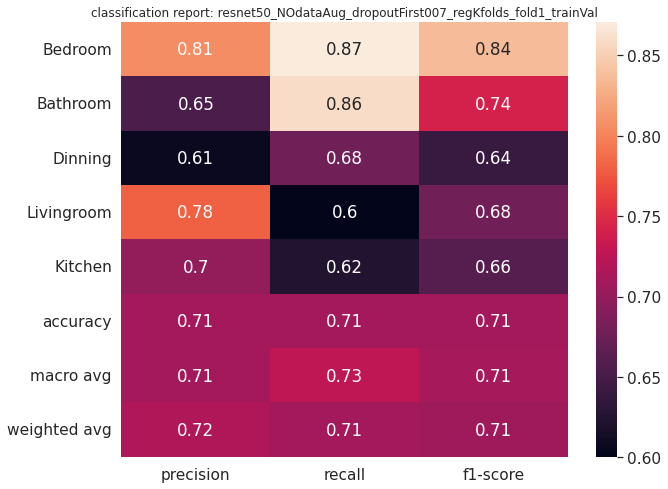

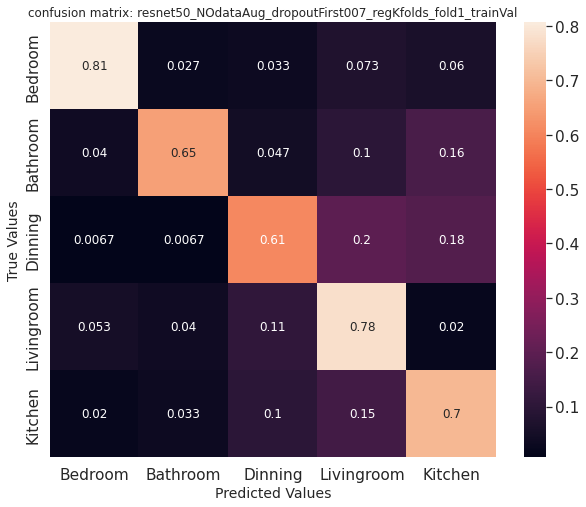

In [ ]:
for f in remaining_folders:
    print("\n ================================",
          "\n FOLDER : ",f)
    print("train dataset")
    train_path = reg_input+f+"/"+'train_ds/'
    train_ds = image_dataset_from_directory(
        train_path,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )

    print("\n test dataset")
    test_path = reg_input+f+"/"+"test_ds"
    test_ds = image_dataset_from_directory(
      test_path,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
    )

    class_names = train_ds.class_names
    print(class_names)

    # # checking numbers non sense now because all have same volume
    # paths = ['train_ds/', 'test_ds/']
    # for p in paths:
    #     for dir,subdir,files in os.walk(reg_input+f+"/"+p):
    #         print(dir,' => ', p, str(len(files)))

    # calling model
    model_name, nn = list(models_dict.items())[0]
    print("\n", model_name)
    nn.summary()

    nn.compile( optimizer = opt, #"adam", 
                  loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                  metrics=['accuracy'] # "recall"
                  )

    # # ====== USING TEST DATASET ======

    history = nn.fit(
          train_ds,
          validation_data=test_ds,
          epochs=epochs,
          #callbacks = callbacks # <=== REMOVE CALLBACK for full results
          )

    number_of_epochs_it_ran = len(history.history['loss']) 
    print("run epochs: ",number_of_epochs_it_ran)
    name = model_name+"_regKfolds_"+f
    #models_dict[m].save(output_folder+name+".h5")

    # saving model accuracy/loss graph
    plotting_model(history,number_of_epochs_it_ran, name, output_folder, "test") 

    # saving model metrics to json
    evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation, output_folder, name+"_trainTest")

    # get inferences
    y_pred_float = nn.predict(test_ds)
    y_pred = np.argmax(y_pred_float, axis=1)

    # get real labels
    y_target = tf.concat([y for x, y in test_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred, y_target,  class_names, output_folder, name+"_trainTest")
    confusion_matrix_report(y_pred, y_target, class_names, output_folder, name+"_trainTest")

    # ====== USING VAL DATASET ======

    # saving model metrics to json
    evaluation_val = nn.evaluate(val_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation_val, output_folder, name+"_trainVal")

    # get inferences
    y_pred_float_val = nn.predict(val_ds)
    y_pred_val = np.argmax(y_pred_float_val, axis=1)

    # get real labels for val_ds
    y_target_val = tf.concat([y for x, y in val_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_val, y_target_val,  class_names, output_folder, name+"_trainVal")
    confusion_matrix_report(y_pred_val, y_target_val, class_names, output_folder, name+"_trainVal")

# Irregular partitions for train set

The motivation is to check performance vs lack of data. Then:

- 150 pics for each class are saved in the val_ds (indeed, the very same than before)
- with the rest of them, 4 subfolders are created. each time the data is randomly shuffled:
  - 20% are stored in test_ds folder
  - 80%, 62%, 46%, 30% of the remaining pics are saved for the train dataset. The rest is discarded.



In [ ]:
os.listdir(irreg_input)

['fold30', 'fold80', 'fold46', 'fold62']

In [ ]:
total = 0
for root, dirs, files in os.walk(irreg_input):
    total += len(files)
    print(dirs, len(files))

['fold30', 'fold80', 'fold46', 'fold62'] 0
['train_ds', 'test_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 241
[] 263
[] 269
[] 195
[] 109
['Dinning', 'Bathroom', 'Bedroom', 'Kitchen', 'Livingroom'] 0
[] 202
[] 92
[] 220
[] 163
[] 225
['train_ds', 'test_ds'] 0
['Dinning', 'Livingroom', 'Bedroom', 'Kitchen', 'Bathroom'] 0
[] 644
[] 718
[] 702
[] 521
[] 291
['Dinning', 'Kitchen', 'Livingroom', 'Bedroom', 'Bathroom'] 0
[] 202
[] 163
[] 225
[] 220
[] 92
['train_ds', 'test_ds'] 0
['Bedroom', 'Livingroom', 'Dinning', 'Bathroom', 'Kitchen'] 0
[] 403
[] 413
[] 370
[] 167
[] 299
['Dinning', 'Bathroom', 'Kitchen', 'Livingroom', 'Bedroom'] 0
[] 202
[] 92
[] 163
[] 225
[] 220
['test_ds', 'train_ds'] 0
['Dinning', 'Kitchen', 'Bedroom', 'Livingroom', 'Bathroom'] 0
[] 202
[] 163
[] 220
[] 225
[] 92
['Bedroom', 'Dinning', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 544
[] 499
[] 556
[] 404
[] 225


In [ ]:
remaining_folders_irr = os.listdir(irreg_input)[1:]
remaining_folders_irr


 FOLDER :  fold30
train dataset
Found 1077 files belonging to 5 classes.

 test dataset
Found 902 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold30/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold30/train_ds/Dinning  =>  train_ds/ 241
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold30/train_ds/Bedroom  =>  train_ds/ 263
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold30/train_ds/Livingroom  =>  train_ds/ 269
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 326s 38s/step - loss: 16.5512 - accuracy: 0.7976 - val_loss: 14.7316 - val_accuracy: 0.8004
Epoch 2/250
9/9 [==============================] - 4s 416ms/step - loss: 14.2181 - accuracy: 0.8032 - val_loss: 7.4436 - val_accuracy: 0.8736
Epoch 3/250
9/9 [==============================] - 4s 412ms/step - loss: 9.7398 - accuracy: 0.8552 - val_loss: 8.3858 - val_accuracy: 0.8603
Epoch 4/250
9/9 [==============================] - 4s 416ms/step - loss: 7.0357 - accuracy: 0.8784 - val_loss: 7.1717 - val_accuracy: 0.8758
Epoch 5/250
9/9 [==============================] - 4s 419ms/step - loss: 7.5447 - accuracy: 0.8802 - val_loss: 7.3279 - val_accuracy: 0.8814
Epoch 6/250
9/9 [==============================] - 4s 412ms/step - loss: 6.8558 - accuracy: 0.8858 - val_loss: 7.1620 - val_accuracy: 0.8803
Epoch 7/250
9/9 [==============================] - 4s 423ms/step - loss: 7.0203 - accuracy: 0.8849 - val_loss: 7.2383 - val_accuracy: 0.8725
Epoch 8/250
9/9 [=====

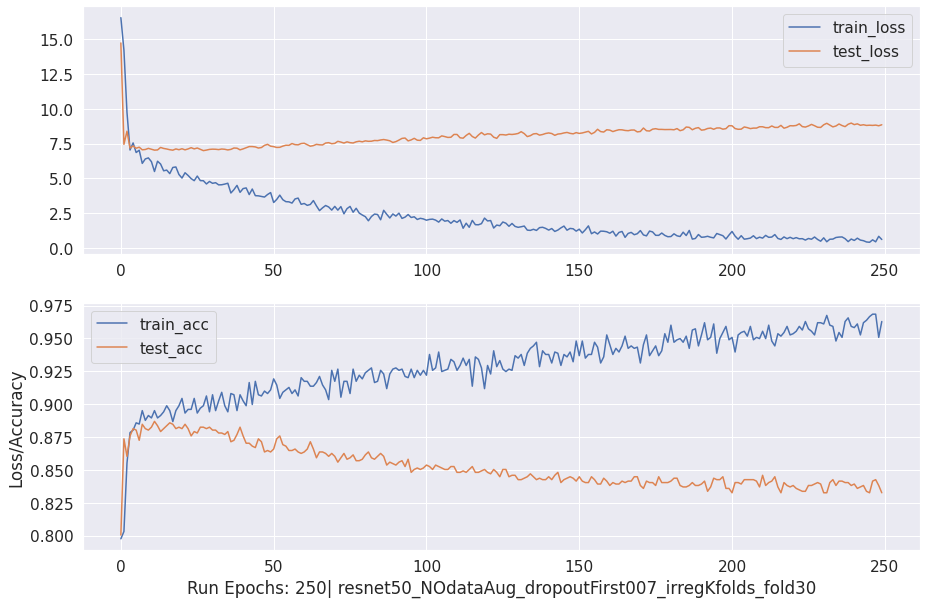

8/8 [==============================] - 2s 200ms/step - loss: 8.8501 - accuracy: 0.8326
              precision    recall  f1-score   support

     Bedroom       0.90      0.82      0.86       239
    Bathroom       0.86      0.89      0.87        89
     Dinning       0.78      0.88      0.83       180
  Livingroom       0.78      0.80      0.79       220
     Kitchen       0.87      0.82      0.84       174

    accuracy                           0.83       902
   macro avg       0.84      0.84      0.84       902
weighted avg       0.84      0.83      0.83       902



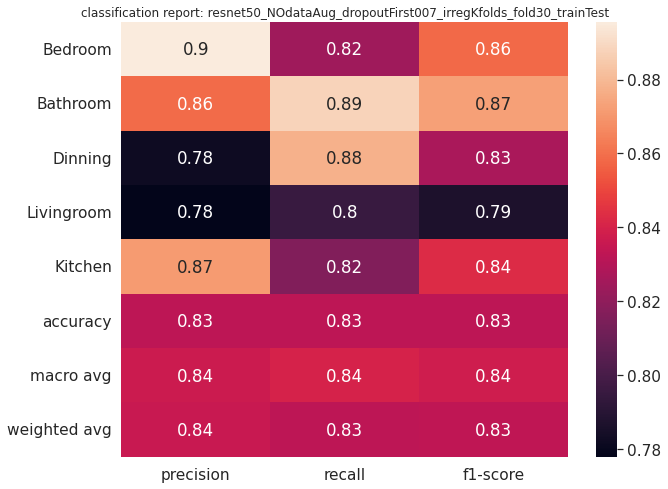

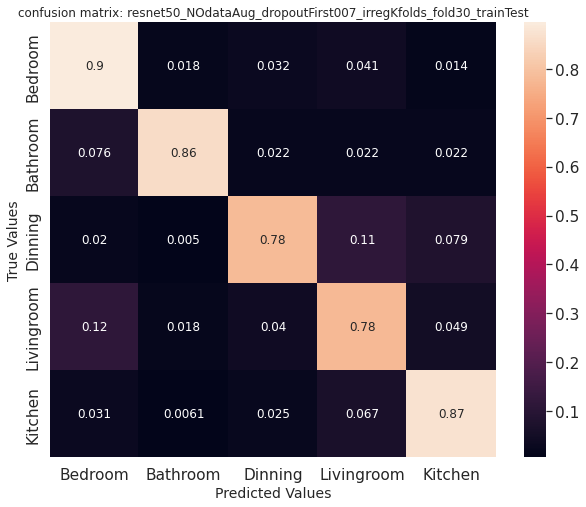

6/6 [==============================] - 1s 218ms/step - loss: 22.4574 - accuracy: 0.6787
              precision    recall  f1-score   support

     Bedroom       0.84      0.70      0.76       181
    Bathroom       0.69      0.87      0.77       119
     Dinning       0.63      0.61      0.62       155
  Livingroom       0.59      0.60      0.60       148
     Kitchen       0.63      0.65      0.64       147

    accuracy                           0.68       750
   macro avg       0.68      0.69      0.68       750
weighted avg       0.68      0.68      0.68       750



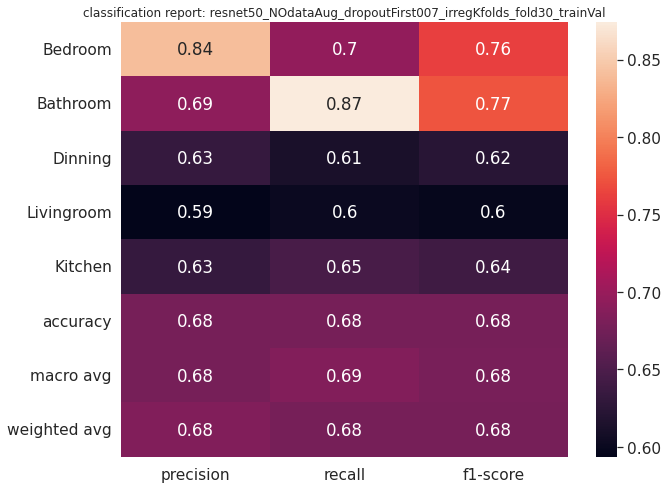

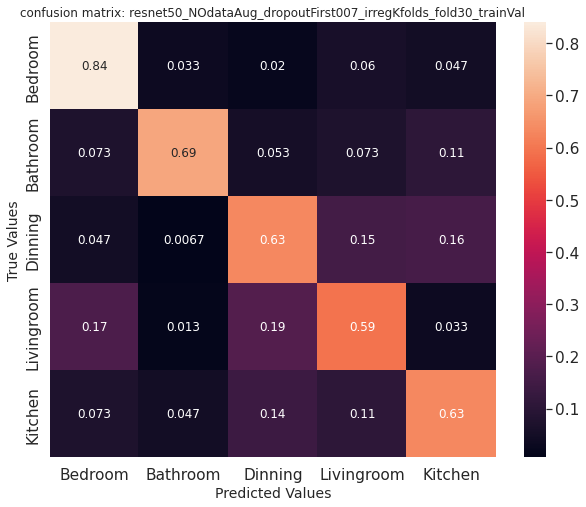


 FOLDER :  fold80
train dataset
Found 2876 files belonging to 5 classes.

 test dataset
Found 902 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold80/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold80/train_ds/Dinning  =>  train_ds/ 644
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold80/train_ds/Livingroom  =>  train_ds/ 718
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1val_5traintest_folders/train_test_ds/traintest_irregular_partitions/fold80/train_ds/Bedroom  =>  train_ds/ 702
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - 594s 26s/step - loss: 8.9642 - accuracy: 0.8164 - val_loss: 7.1864 - val_accuracy: 0.8514
Epoch 2/250
23/23 [==============================] - 7s 297ms/step - loss: 17.8476 - accuracy: 0.7024 - val_loss: 6.7368 - val_accuracy: 0.8570
Epoch 3/250
23/23 [==============================] - 7s 300ms/step - loss: 21.1639 - accuracy: 0.6592 - val_loss: 6.0731 - val_accuracy: 0.8747
Epoch 4/250
23/23 [==============================] - 7s 304ms/step - loss: 24.3254 - accuracy: 0.6419 - val_loss: 6.2259 - val_accuracy: 0.8681
Epoch 5/250
23/23 [==============================] - 7s 299ms/step - loss: 28.0077 - accuracy: 0.6151 - val_loss: 6.2051 - val_accuracy: 0.8758
Epoch 6/250
23/23 [==============================] - 7s 294ms/step - loss: 29.4414 - accuracy: 0.5987 - val_loss: 6.6200 - val_accuracy: 0.8603
Epoch 7/250
23/23 [==============================] - 7s 292ms/step - loss: 27.5953 - accuracy: 0.6259 - val_loss: 6.7297 - val_accuracy: 0.8714
Epoch

In [ ]:
for f in remaining_folders_irr:
    print("\n ================================",
          "\n FOLDER : ",f)
    print("train dataset")
    train_path = irreg_input+f+"/"+'train_ds/'
    train_ds = image_dataset_from_directory(
        train_path,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )

    print("\n test dataset")
    test_path = irreg_input+f+"/"+"test_ds"
    test_ds = image_dataset_from_directory(
      test_path,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
    )

    class_names = train_ds.class_names
    print(class_names)

    # checking numbers non sense now because all have same volume
    paths = ['train_ds/', 'test_ds/']
    for p in paths:
        for dir,subdir,files in os.walk(irreg_input+f+"/"+p):
            print(dir,' => ', p, str(len(files)))

    # calling model
    model_name, nn = list(models_dict.items())[0]
    print("\n", model_name)
    nn.summary()

    nn.compile( optimizer = opt, #"adam", 
                  loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                  metrics=['accuracy'] # "recall"
                  )

  # # ====== USING TEST DATASET ======

    history = nn.fit(
          train_ds,
          validation_data=test_ds,
          epochs=epochs,
          #callbacks = callbacks # <=== REMOVE CALLBACK for full results
          )

    number_of_epochs_it_ran = len(history.history['loss']) 
    print("run epochs: ",number_of_epochs_it_ran)
    name = model_name+"_irregKfolds_"+f
    #models_dict[m].save(output_folder+name+".h5")

    # saving model accuracy/loss graph
    plotting_model(history,number_of_epochs_it_ran, name, output_folder, "test") 

    # saving model metrics to json
    evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation, output_folder, name+"_trainTest")

    # get inferences
    y_pred_float = nn.predict(test_ds)
    y_pred = np.argmax(y_pred_float, axis=1)

    # get real labels
    y_target = tf.concat([y for x, y in test_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred, y_target,  class_names, output_folder, name+"_trainTest")
    confusion_matrix_report(y_pred, y_target, class_names, output_folder, name+"_trainTest")

    # ====== USING VAL DATASET ======

    # saving model metrics to json
    evaluation_val = nn.evaluate(val_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation_val, output_folder, name+"_trainVal")

    # get inferences
    y_pred_float_val = nn.predict(val_ds)
    y_pred_val = np.argmax(y_pred_float_val, axis=1)

    # get real labels for val_ds
    y_target_val = tf.concat([y for x, y in val_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_val, y_target_val,  class_names, output_folder, name+"_trainVal")
    confusion_matrix_report(y_pred_val, y_target_val, class_names, output_folder, name+"_trainVal")